C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Getting and resizing train images and masks ... 


100%|█████████████████████████████████████████████████████| 670/670 [01:47<00:00,  6.23it/s]


Getting and resizing test images ... 


100%|███████████████████████████████████████████████████████| 65/65 [00:00<00:00, 76.28it/s]


Done!


C:\Program Files\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


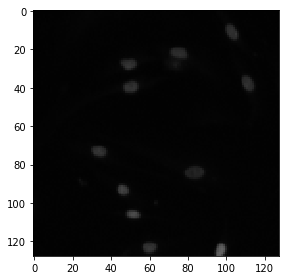

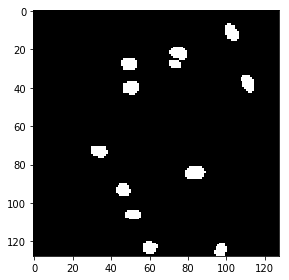

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [2]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [3]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 128, 128, 16) 4624        concatenate_4[0][0]              
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 128, 128, 16) 0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 128, 128, 16) 2320        dropout_9[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 1)  17          conv2d_18[0][0]                  
Total params: 1,941,105
Trainable params: 1,941,105
Non-trainable params: 0
__________________________________________________________________________________________________


In [4]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/50
603/603 [==============================] - ETA: 2:00 - loss: 0.7160 - mean_iou: 0.0000e+ - ETA: 1:32 - loss: 0.6575 - mean_iou: 0.2070   - ETA: 1:20 - loss: 0.6283 - mean_iou: 0.27 - ETA: 1:14 - loss: 0.6139 - mean_iou: 0.31 - ETA: 1:10 - loss: 0.6107 - mean_iou: 0.33 - ETA: 1:06 - loss: 0.5832 - mean_iou: 0.34 - ETA: 1:03 - loss: 0.5633 - mean_iou: 0.35 - ETA: 1:00 - loss: 0.5415 - mean_iou: 0.36 - ETA: 58s - loss: 0.5245 - mean_iou: 0.3705 - ETA: 56s - loss: 0.5128 - mean_iou: 0.375 - ETA: 53s - loss: 0.5069 - mean_iou: 0.380 - ETA: 51s - loss: 0.5009 - mean_iou: 0.383 - ETA: 49s - loss: 0.4918 - mean_iou: 0.386 - ETA: 47s - loss: 0.4894 - mean_iou: 0.389 - ETA: 45s - loss: 0.4908 - mean_iou: 0.391 - ETA: 44s - loss: 0.4882 - mean_iou: 0.393 - ETA: 42s - loss: 0.4824 - mean_iou: 0.395 - ETA: 39s - loss: 0.4762 - mean_iou: 0.396 - ETA: 38s - loss: 0.4650 - mean_iou: 0.398 - ETA: 36s - loss: 0.4649 - mean_iou: 0.399 - ETA: 34s - l

603/603 [==============================] - ETA: 1:09 - loss: 0.0622 - mean_iou: 0.60 - ETA: 1:07 - loss: 0.0865 - mean_iou: 0.60 - ETA: 1:05 - loss: 0.1347 - mean_iou: 0.60 - ETA: 1:03 - loss: 0.1379 - mean_iou: 0.60 - ETA: 1:02 - loss: 0.1348 - mean_iou: 0.60 - ETA: 1:00 - loss: 0.1260 - mean_iou: 0.60 - ETA: 59s - loss: 0.1173 - mean_iou: 0.6081 - ETA: 57s - loss: 0.1202 - mean_iou: 0.608 - ETA: 55s - loss: 0.1240 - mean_iou: 0.608 - ETA: 53s - loss: 0.1246 - mean_iou: 0.609 - ETA: 51s - loss: 0.1192 - mean_iou: 0.609 - ETA: 49s - loss: 0.1224 - mean_iou: 0.610 - ETA: 47s - loss: 0.1225 - mean_iou: 0.610 - ETA: 45s - loss: 0.1232 - mean_iou: 0.610 - ETA: 43s - loss: 0.1233 - mean_iou: 0.611 - ETA: 41s - loss: 0.1259 - mean_iou: 0.611 - ETA: 39s - loss: 0.1238 - mean_iou: 0.612 - ETA: 37s - loss: 0.1270 - mean_iou: 0.612 - ETA: 35s - loss: 0.1283 - mean_iou: 0.613 - ETA: 33s - loss: 0.1305 - mean_iou: 0.613 - ETA: 31s - loss: 0.1301 - mean_iou: 0.613 - ETA: 29s - loss: 0.1287 - mean_i

603/603 [==============================] - ETA: 1:10 - loss: 0.1254 - mean_iou: 0.69 - ETA: 1:09 - loss: 0.1035 - mean_iou: 0.69 - ETA: 1:07 - loss: 0.0992 - mean_iou: 0.69 - ETA: 1:04 - loss: 0.0926 - mean_iou: 0.69 - ETA: 1:02 - loss: 0.0888 - mean_iou: 0.69 - ETA: 1:00 - loss: 0.0960 - mean_iou: 0.69 - ETA: 58s - loss: 0.0947 - mean_iou: 0.6981 - ETA: 56s - loss: 0.0932 - mean_iou: 0.698 - ETA: 54s - loss: 0.0902 - mean_iou: 0.698 - ETA: 52s - loss: 0.0910 - mean_iou: 0.698 - ETA: 50s - loss: 0.0911 - mean_iou: 0.698 - ETA: 48s - loss: 0.0912 - mean_iou: 0.699 - ETA: 46s - loss: 0.0932 - mean_iou: 0.699 - ETA: 44s - loss: 0.0926 - mean_iou: 0.699 - ETA: 42s - loss: 0.0945 - mean_iou: 0.699 - ETA: 41s - loss: 0.0967 - mean_iou: 0.699 - ETA: 39s - loss: 0.0947 - mean_iou: 0.699 - ETA: 37s - loss: 0.0946 - mean_iou: 0.700 - ETA: 35s - loss: 0.0975 - mean_iou: 0.700 - ETA: 33s - loss: 0.0961 - mean_iou: 0.700 - ETA: 31s - loss: 0.0963 - mean_iou: 0.700 - ETA: 29s - loss: 0.0958 - mean_i

603/603 [==============================] - ETA: 1:13 - loss: 0.1075 - mean_iou: 0.73 - ETA: 1:10 - loss: 0.0939 - mean_iou: 0.73 - ETA: 1:08 - loss: 0.0972 - mean_iou: 0.73 - ETA: 1:05 - loss: 0.0949 - mean_iou: 0.73 - ETA: 1:03 - loss: 0.1025 - mean_iou: 0.73 - ETA: 1:01 - loss: 0.0988 - mean_iou: 0.73 - ETA: 59s - loss: 0.0992 - mean_iou: 0.7394 - ETA: 57s - loss: 0.0947 - mean_iou: 0.739 - ETA: 54s - loss: 0.0948 - mean_iou: 0.739 - ETA: 53s - loss: 0.0965 - mean_iou: 0.739 - ETA: 51s - loss: 0.0947 - mean_iou: 0.739 - ETA: 49s - loss: 0.0930 - mean_iou: 0.739 - ETA: 47s - loss: 0.0911 - mean_iou: 0.739 - ETA: 45s - loss: 0.0915 - mean_iou: 0.739 - ETA: 43s - loss: 0.0905 - mean_iou: 0.739 - ETA: 41s - loss: 0.0884 - mean_iou: 0.740 - ETA: 40s - loss: 0.0867 - mean_iou: 0.740 - ETA: 38s - loss: 0.0858 - mean_iou: 0.740 - ETA: 36s - loss: 0.0859 - mean_iou: 0.740 - ETA: 34s - loss: 0.0870 - mean_iou: 0.740 - ETA: 32s - loss: 0.0871 - mean_iou: 0.740 - ETA: 30s - loss: 0.0864 - mean_i

603/603 [==============================] - ETA: 1:07 - loss: 0.0576 - mean_iou: 0.76 - ETA: 1:06 - loss: 0.0671 - mean_iou: 0.76 - ETA: 1:04 - loss: 0.0723 - mean_iou: 0.76 - ETA: 1:02 - loss: 0.0777 - mean_iou: 0.76 - ETA: 1:00 - loss: 0.0782 - mean_iou: 0.76 - ETA: 58s - loss: 0.0756 - mean_iou: 0.7627 - ETA: 57s - loss: 0.0767 - mean_iou: 0.762 - ETA: 55s - loss: 0.0816 - mean_iou: 0.762 - ETA: 53s - loss: 0.0780 - mean_iou: 0.762 - ETA: 51s - loss: 0.0804 - mean_iou: 0.763 - ETA: 49s - loss: 0.0804 - mean_iou: 0.763 - ETA: 47s - loss: 0.0809 - mean_iou: 0.763 - ETA: 45s - loss: 0.0801 - mean_iou: 0.763 - ETA: 43s - loss: 0.0810 - mean_iou: 0.763 - ETA: 41s - loss: 0.0810 - mean_iou: 0.763 - ETA: 40s - loss: 0.0813 - mean_iou: 0.763 - ETA: 38s - loss: 0.0806 - mean_iou: 0.763 - ETA: 36s - loss: 0.0799 - mean_iou: 0.763 - ETA: 34s - loss: 0.0787 - mean_iou: 0.763 - ETA: 32s - loss: 0.0791 - mean_iou: 0.763 - ETA: 30s - loss: 0.0797 - mean_iou: 0.763 - ETA: 28s - loss: 0.0824 - mean_i

603/603 [==============================] - ETA: 1:07 - loss: 0.0968 - mean_iou: 0.77 - ETA: 1:05 - loss: 0.0925 - mean_iou: 0.77 - ETA: 1:03 - loss: 0.0852 - mean_iou: 0.77 - ETA: 1:01 - loss: 0.0821 - mean_iou: 0.77 - ETA: 1:00 - loss: 0.0774 - mean_iou: 0.77 - ETA: 58s - loss: 0.0878 - mean_iou: 0.7798 - ETA: 56s - loss: 0.0890 - mean_iou: 0.779 - ETA: 54s - loss: 0.0852 - mean_iou: 0.779 - ETA: 52s - loss: 0.0894 - mean_iou: 0.779 - ETA: 50s - loss: 0.0913 - mean_iou: 0.780 - ETA: 49s - loss: 0.0909 - mean_iou: 0.780 - ETA: 47s - loss: 0.0897 - mean_iou: 0.780 - ETA: 45s - loss: 0.0897 - mean_iou: 0.780 - ETA: 43s - loss: 0.0912 - mean_iou: 0.780 - ETA: 41s - loss: 0.0917 - mean_iou: 0.780 - ETA: 39s - loss: 0.0918 - mean_iou: 0.780 - ETA: 38s - loss: 0.0912 - mean_iou: 0.780 - ETA: 36s - loss: 0.0910 - mean_iou: 0.780 - ETA: 34s - loss: 0.0913 - mean_iou: 0.780 - ETA: 32s - loss: 0.0899 - mean_iou: 0.780 - ETA: 30s - loss: 0.0883 - mean_iou: 0.780 - ETA: 28s - loss: 0.0881 - mean_i

603/603 [==============================] - ETA: 1:08 - loss: 0.0561 - mean_iou: 0.79 - ETA: 1:06 - loss: 0.0655 - mean_iou: 0.79 - ETA: 1:05 - loss: 0.0784 - mean_iou: 0.79 - ETA: 1:03 - loss: 0.0739 - mean_iou: 0.79 - ETA: 1:01 - loss: 0.0724 - mean_iou: 0.79 - ETA: 59s - loss: 0.0746 - mean_iou: 0.7920 - ETA: 57s - loss: 0.0826 - mean_iou: 0.792 - ETA: 55s - loss: 0.0836 - mean_iou: 0.792 - ETA: 53s - loss: 0.0834 - mean_iou: 0.792 - ETA: 51s - loss: 0.0857 - mean_iou: 0.792 - ETA: 49s - loss: 0.0843 - mean_iou: 0.792 - ETA: 47s - loss: 0.0824 - mean_iou: 0.792 - ETA: 45s - loss: 0.0810 - mean_iou: 0.792 - ETA: 44s - loss: 0.0800 - mean_iou: 0.792 - ETA: 42s - loss: 0.0780 - mean_iou: 0.792 - ETA: 40s - loss: 0.0778 - mean_iou: 0.792 - ETA: 38s - loss: 0.0776 - mean_iou: 0.792 - ETA: 36s - loss: 0.0778 - mean_iou: 0.792 - ETA: 34s - loss: 0.0797 - mean_iou: 0.792 - ETA: 32s - loss: 0.0781 - mean_iou: 0.792 - ETA: 30s - loss: 0.0780 - mean_iou: 0.792 - ETA: 29s - loss: 0.0771 - mean_i

603/603 [==============================] - ETA: 1:07 - loss: 0.0622 - mean_iou: 0.80 - ETA: 1:05 - loss: 0.0737 - mean_iou: 0.80 - ETA: 1:03 - loss: 0.0715 - mean_iou: 0.80 - ETA: 1:02 - loss: 0.0674 - mean_iou: 0.80 - ETA: 1:00 - loss: 0.0621 - mean_iou: 0.80 - ETA: 58s - loss: 0.0636 - mean_iou: 0.8017 - ETA: 56s - loss: 0.0675 - mean_iou: 0.801 - ETA: 54s - loss: 0.0669 - mean_iou: 0.801 - ETA: 52s - loss: 0.0650 - mean_iou: 0.801 - ETA: 51s - loss: 0.0678 - mean_iou: 0.801 - ETA: 49s - loss: 0.0673 - mean_iou: 0.801 - ETA: 47s - loss: 0.0704 - mean_iou: 0.801 - ETA: 45s - loss: 0.0685 - mean_iou: 0.801 - ETA: 43s - loss: 0.0680 - mean_iou: 0.801 - ETA: 41s - loss: 0.0677 - mean_iou: 0.802 - ETA: 39s - loss: 0.0686 - mean_iou: 0.802 - ETA: 38s - loss: 0.0700 - mean_iou: 0.802 - ETA: 36s - loss: 0.0697 - mean_iou: 0.802 - ETA: 34s - loss: 0.0696 - mean_iou: 0.802 - ETA: 32s - loss: 0.0695 - mean_iou: 0.802 - ETA: 30s - loss: 0.0695 - mean_iou: 0.802 - ETA: 28s - loss: 0.0687 - mean_i

In [6]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - ETA:  - ETA:  - 2s 36ms/step


C:\Program Files\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


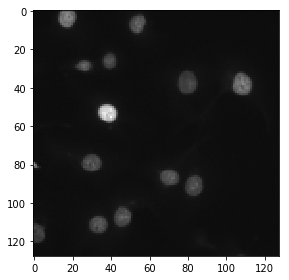

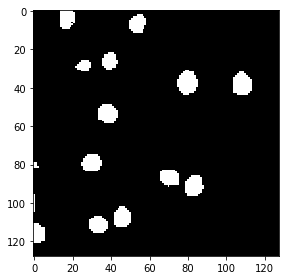

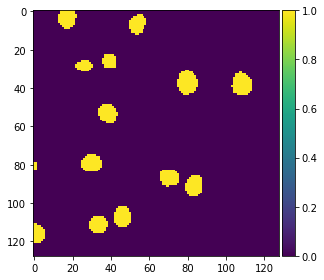

In [9]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

C:\Program Files\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


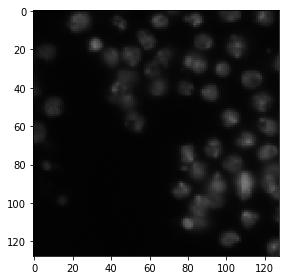

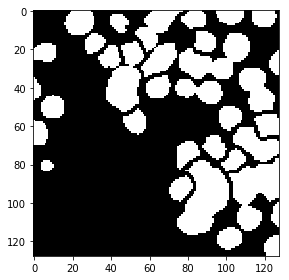

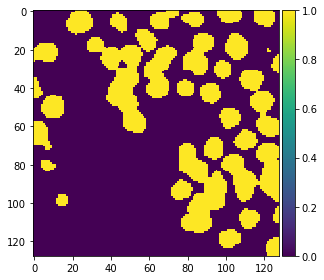

In [10]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

In [11]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [12]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('submission_ds_bowl_2018_3_23.csv', index=False)